In [1]:
# !pip install gtts pydub audioop-lts
from gtts import gTTS
from pydub import AudioSegment
import time
import os
import pandas as pd
import glob
from collections import defaultdict
pd.options.display.max_columns = 100

# 0. Load data

In [2]:
cols_keep = [
    'chinese', 'pinyin', 'english',
    'type', 'priority', 'known', 'known_pinyin_prompt', 'known_english_prompt',
    'phonetic', 'category1', 'quality',
    'word1', 'word1_english', 'word2', 'word2_english', 'word3', 'word3_english', 'word4', 'word4_english',
    'sentence', 'sentence_pinyin', 'sentence_english', 'date']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=0'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['chinese', 'english'])
print(df.shape)
df.head()

(4565, 23)


,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date
0,理解,lǐ jiě,to understand;comprehend,combo,1.0,5.0,2.0,5.0,NaN,verb,5.0,管理,to manage,解决,to resolve,NaN,NaN,NaN,NaN,我完全理解你的想法,Wǒ wánquán lǐjiě nǐ de xiǎngfǎ,I totally understand your thinking,NaN
1,风扇,fēng shàn,electric fan,combo,1.0,2.0,2.0,5.0,NaN,electronics,4.0,风,wind,扇,fan,NaN,NaN,NaN,NaN,风扇开得太大了,Fēngshàn kāi de tài dà le,The fan is on too high,NaN
2,降低,jiàng dī,to lower;reduce,combo,1.0,5.0,5.0,5.0,NaN,change,4.0,降,to drop,低,low,NaN,NaN,NaN,NaN,我们需要降低成本,Wǒmen xūyào jiàngdī chéngběn,We need to lower the cost,NaN
3,王朝,wáng cháo,dynasty,combo,1.0,5.0,1.0,5.0,NaN,china,3.0,王,king,朝鲜,North Korea,NaN,NaN,NaN,NaN,这是一个古老的王朝,Zhè shì yī gè gǔlǎo de wángcháo,This is an ancient dynasty,NaN
4,总理,zǒng lǐ,prime minister,combo,1.0,5.0,5.0,5.0,NaN,society,3.0,总是,always,管理,to manage,NaN,NaN,NaN,NaN,总理今天要来学校,Zǒnglǐ jīntiān yào lái xuéxiào,The prime minister is coming to the school today,NaN


# 1. Example create and combine mp3

In [4]:
start_time = time.time()

# Create Chinese TTS
tts_chinese = gTTS("乐极生悲", lang="zh-cn")
tts_chinese.save("chinese.mp3")
tts_chinese_time = time.time() - start_time
print(f"Chinese TTS created in {tts_chinese_time:.2f} seconds")

# Create English TTS
tts_english = gTTS("Extreme joy begets sorrow.", lang="en")
tts_english.save("english.mp3")
tts_english_time = time.time() - start_time - tts_chinese_time
print(f"English TTS created in {tts_english_time:.2f} seconds")

start_time = time.time()
# Load the audio files
chinese_audio = AudioSegment.from_mp3("chinese.mp3")
chinese_audio_time = time.time() - start_time
print(f"Chinese audio loaded in {chinese_audio_time:.2f} seconds")
english_audio = AudioSegment.from_mp3("english.mp3")
english_audio_time = time.time() - start_time - chinese_audio_time
print(f"English audio loaded in {english_audio_time:.2f} seconds")

# Create a 500ms silent pause
pause = AudioSegment.silent(duration=500)
pause_time = time.time() - start_time - chinese_audio_time - english_audio_time
print(f"Pause created in {pause_time:.2f} seconds")

# Concatenate: chinese -> pause -> english
combined = chinese_audio + pause + english_audio
combined_time = time.time() - start_time - chinese_audio_time - english_audio_time - pause_time
print(f"Combined audio in {combined_time:.2f} seconds")

# Export the combined audio
combined.export("combined.mp3", format="mp3")
export_time = time.time() - start_time - chinese_audio_time - english_audio_time - pause_time - combined_time
print(f"Exported combined audio in {export_time:.2f} seconds")

Chinese TTS created in 1.92 seconds
English TTS created in 1.44 seconds
Chinese audio loaded in 0.19 seconds
English audio loaded in 0.07 seconds
Pause created in 0.00 seconds
Combined audio in 0.00 seconds
Exported combined audio in 0.06 seconds


# 2. Process data for first long recording

In [23]:
cols_keep = ['english', '中文', '优先', '记忆', '难易', '例句']
sheet_url = 'https://docs.google.com/spreadsheets/d/1pw9EAIvtiWenPDBFBIf7pwTh0FvIbIR0c3mY5gJwlDk/edit#gid=47045332'
sheet_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(sheet_url)[cols_keep]
df = df.dropna(subset=['中文', 'english'])
print(df.shape)
df.head()

(115, 6)


,english,中文,优先,记忆,难易,例句
0,mouth feel,口感,1.0,NaN,1.0,This orange juice has a dense mouth feel
1,dense,稠密,2.0,NaN,1.0,"a dark, dense novel； dense smoke；dense 火山岩; he..."
2,scribble,涂,3.0,1.0,2.0,"I got bored during the lecture, so I scribbled..."
3,squiggle,曲线,3.0,1.0,2.0,NaN
4,overstate,夸大,1.0,1.0,2.0,that advertisement really overstated the effec...


In [24]:
df_create_audio = df.sort_values(['优先', '记忆'], ascending=[True, False]).head(20).reset_index(drop=True)
df_create_audio

,english,中文,优先,记忆,难易,例句
0,overwrite,覆盖,1.0,3.0,2.0,Be careful not to overwrite the important docu...
1,complement,合作,1.0,3.0,2.0,The two teammates complement each other since ...
2,overstate,夸大,1.0,1.0,2.0,that advertisement really overstated the effec...
3,converter,转换器,1.0,1.0,2.0,i need a converter to charge my iphone. really...
4,gullible,容易受骗,1.0,1.0,3.0,You must be so gullible to fall for that scam.
5,nostalgic,怀旧的,1.0,1.0,2.0,listening to this song makes me feel very nost...
6,evaluate,评价,1.0,1.0,2.0,She will evaluate the draft design and suggest...
7,twist,扭,1.0,1.0,2.0,Twist the sunflower seed with your fingertip
8,paranoid,偏执,1.0,1.0,3.0,you think I'm paranoid but I tell you there is...
9,ambiguity,歧义、双关,1.0,1.0,3.0,The interpretation is ambiguous because analyz...


# 3. Create audio files

In [25]:
start_time = time.time()

for i_row, row in df_create_audio.iterrows():
    tts_chinese = gTTS(row['中文'], lang="zh-cn")
    tts_chinese.save("audio_files/chinese_tmp.mp3")
    tts_chinese_time = time.time()
    print(f"{(tts_chinese_time-start_time):.2f} seconds, row {i_row}, {row['中文']}")

    tts_english = gTTS(row['english'], lang="en")
    tts_english.save("audio_files/english_tmp.mp3")
    tts_english_time = time.time()
    print(f"{(tts_english_time-tts_chinese_time):.2f} seconds, row {i_row}, {row['english']}")
    
    tts_sent = gTTS(row['例句'], lang="en")
    tts_sent.save("audio_files/sent_tmp.mp3")
    tts_sent_time = time.time()
    print(f"{(tts_sent_time-tts_english_time):.2f} seconds, row {i_row}, {row['例句']}")

    chinese_audio = AudioSegment.from_mp3("audio_files/chinese_tmp.mp3")
    english_audio = AudioSegment.from_mp3("audio_files/english_tmp.mp3")
    sent_audio = AudioSegment.from_mp3("audio_files/sent_tmp.mp3")
    pause_500ms = AudioSegment.silent(duration=500)
    pause_1000ms = AudioSegment.silent(duration=1000)
    combined = english_audio + pause_500ms + chinese_audio + pause_500ms + sent_audio + pause_1000ms
    combined.export(f"audio_files/combined_row{i_row}.mp3", format="mp3")
    combined_time = time.time()
    print(f"{(combined_time-tts_sent_time):.2f} seconds, row {i_row}, combined audio")

2.01 seconds, row 0, 覆盖
0.96 seconds, row 0, overwrite
1.84 seconds, row 0, Be careful not to overwrite the important document when saving the new version.
0.39 seconds, row 0, combined audio
6.90 seconds, row 1, 合作
1.00 seconds, row 1, complement
2.08 seconds, row 1, The two teammates complement each other since they are strong in different areas.
0.31 seconds, row 1, combined audio
11.95 seconds, row 2, 夸大
1.40 seconds, row 2, overstate
1.89 seconds, row 2, that advertisement really overstated the effect of the product
0.32 seconds, row 2, combined audio
17.34 seconds, row 3, 转换器
1.61 seconds, row 3, converter 
7.59 seconds, row 3, i need a converter to charge my iphone. really, i should have never bought an iphone because now i'm trapped in the apple ecosystem. i vow my next phone will not be an iphone.
0.49 seconds, row 3, combined audio
28.39 seconds, row 4, 容易受骗
1.51 seconds, row 4, gullible
1.97 seconds, row 4, You must be so gullible to fall for that scam.
0.31 seconds, row 4, 

In [26]:
# Combine the audio files into a single file
all_audio_files = []
for i_row in range(len(df_create_audio)):
    audio_file = f"audio_files/combined_row{i_row}.mp3"
    if os.path.exists(audio_file):
        all_audio_files.append(AudioSegment.from_mp3(audio_file))

combined = all_audio_files[0]
for audio in all_audio_files[1:]:
    combined += audio
combined.export(f"audio_files/whole_file_v1.mp3", format="mp3")

<_io.BufferedRandom name='audio_files/whole_file_v1.mp3'>

# 4. My high priority words audio file

In [66]:
types_not_allowed = ['phrase', 'sentence', 'part sent', 'phrase_save']
df_this = df[
    (df['priority'] <= 2) & (df['known_english_prompt'] >= 3) & (~df['type'].isin(types_not_allowed))
    ].sort_values(['priority', 'known_pinyin_prompt', 'known', 'category1'], ascending=[False, False, False, False]).reset_index(drop=True)
print(df_this.shape)
df_this.head(10)

(269, 23)


,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date
0,地毯,dì tǎn,carpet;rug,combo,2.0,5.0,5.0,5.0,NaN,thing,1.0,地,ground,毯子,blanket,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-16
1,把手,bǎ shǒu,handle,combo,2.0,5.0,5.0,5.0,NaN,thing,1.0,把,to hold,手,hand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20
2,一战,yī zhàn,World War I,abbreviation,2.0,5.0,5.0,5.0,NaN,society,2.0,一,one,战,war,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20
3,二战,èr zhàn,World War II,abbreviation,2.0,5.0,5.0,5.0,NaN,society,2.0,二,two,战,war,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-20
4,少数民族,shǎo shù mín zú,minority,combo,2.0,5.0,5.0,5.0,NaN,society,1.0,少,few,数,number,民,people,种族,race,NaN,NaN,NaN,2025-07-20
5,争论,zhēng ​lùn,to argue;debate,combo,2.0,5.0,5.0,5.0,NaN,people,2.0,战争,war,讨论,to discuss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,同志,tóng ​zhì,comrade,combo,2.0,5.0,5.0,3.0,NaN,people,2.0,同,same,标志,sign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,树枝,shù zhī,branches (tree),combo,2.0,5.0,5.0,5.0,NaN,outdoor,5.0,树,tree,荔枝,lychee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-08-08
8,简介,jiǎn jiè,summary;introduction,combo,2.0,5.0,5.0,5.0,NaN,language,2.0,简,simple,介绍,to introduce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,前者,qián zhě,the former,combo,2.0,5.0,5.0,5.0,NaN,language,1.0,前,before,或者,or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_this['type'].value_counts()

type
combo           221
no combo         31
two word         11
abbreviation      3
suffix            2
single char       1
Name: count, dtype: int64

In [ ]:
for i_row, row in df_this.loc[139:].iterrows():
    start_time = time.time()
    # NOTE: 'zh' sounds the same, also any top level domain.
    gTTS(row['chinese'], lang="zh-cn").save(f"audio_files/zh/{row['chinese']}.mp3")
    tts_chinese_time = time.time()
    print(f"{(tts_chinese_time-start_time):.2f} seconds, row {i_row}, {row['chinese']}")

    gTTS(row['chinese'], lang="zh-cn", slow=True).save(f"audio_files/zh_slow/{row['chinese']}.mp3")
    tts_chinese_slow_time = time.time()
    print(f"{(tts_chinese_slow_time-start_time):.2f} seconds, row {i_row}, {row['chinese']} slow")

    gTTS(row['chinese'], lang="zh-tw").save(f"audio_files/zh_tw/{row['chinese']}.mp3")
    tts_tw_time = time.time()
    # print(f"{(tts_tw_time-tts_chinese_slow_time):.2f} seconds, row {i_row}, {row['chinese']} tw")
    print(f"{(tts_tw_time-tts_chinese_time):.2f} seconds, row {i_row}, {row['chinese']} tw")

    gTTS(row['english'], lang="en").save(f"audio_files/english/{row['english']}.mp3")
    tts_english_time = time.time()
    print(f"{(tts_english_time-tts_tw_time):.2f} seconds, row {i_row}, {row['english']}")

    chinese_audio = AudioSegment.from_mp3("audio_files/chinese_tmp.mp3")
    tw_audio = AudioSegment.from_mp3("audio_files/tw_tmp.mp3")
    english_audio = AudioSegment.from_mp3("audio_files/english_tmp.mp3")
    pause_500ms = AudioSegment.silent(duration=500)
    pause_1000ms = AudioSegment.silent(duration=1000)
    combined = chinese_audio + pause_500ms + tw_audio + pause_500ms + english_audio + pause_1000ms
    combined.export(f"audio_files/combined_row{i_row}.mp3", format="mp3")
    combined_time = time.time()
    print(f"{(combined_time-tts_english_time):.2f} seconds, row {i_row}, combined audio")

files_rmv = [
    "audio_files/chinese_tmp.mp3",
    "audio_files/tw_tmp.mp3",
    "audio_files/english_tmp.mp3"
    ]
for file_name in files_rmv:
    if os.path.exists(file_name):
        os.remove(file_name)

1.80 seconds, row 139, 名句
1.06 seconds, row 139, 名句 tw
1.36 seconds, row 139, saying;quote;famous saying
0.40 seconds, row 139, combined audio
1.48 seconds, row 140, 拉伸
1.56 seconds, row 140, 拉伸 tw
1.15 seconds, row 140, stretch
0.31 seconds, row 140, combined audio
1.30 seconds, row 141, 症状
1.19 seconds, row 141, 症状 tw
1.60 seconds, row 141, symptom
0.31 seconds, row 141, combined audio
1.72 seconds, row 142, 肩膀
1.32 seconds, row 142, 肩膀 tw
1.08 seconds, row 142, shoulder
0.31 seconds, row 142, combined audio
2.07 seconds, row 143, 组合
1.05 seconds, row 143, 组合 tw
1.13 seconds, row 143, combination
0.33 seconds, row 143, combined audio
1.44 seconds, row 144, 好转
1.11 seconds, row 144, 好转 tw
1.50 seconds, row 144, improve
0.34 seconds, row 144, combined audio
1.41 seconds, row 145, 起不来
1.43 seconds, row 145, 起不来 tw
1.87 seconds, row 145, can't get up
0.32 seconds, row 145, combined audio
1.16 seconds, row 146, 误会
1.40 seconds, row 146, 误会 tw
1.17 seconds, row 146, misunderstand
0.31 seco

In [74]:
# Combine the audio files into a single file
final_file_name = '0813_01_word_p2_k3'
all_audio_files = []
for i_row in range(len(df_this)):
    audio_file = f"audio_files/combined_row{i_row}.mp3"
    if os.path.exists(audio_file):
        all_audio_files.append(AudioSegment.from_mp3(audio_file))

combined = all_audio_files[0]
for audio in all_audio_files[1:]:
    combined += audio
combined.export(f"audio_files/products/{final_file_name}.mp3", format="mp3")

<_io.BufferedRandom name='audio_files/products/0813_01_word_p2_k3.mp3'>

In [53]:
# Remove component files
files_rmv = glob.glob('audio_files/combined_row*.mp3')
for file_name in files_rmv:
    if os.path.exists(file_name):
        os.remove(file_name)

# 5. Creation refactor
1. gtts save in reproducible places
2. combine into vocab sets as desired for current goals
3. combine into whole recording

In [6]:
# Which data to use this time?
types_not_allowed = ['phrase', 'sentence', 'part sent', 'phrase_save']
df_this = (
    df[
        (df['priority'] <= 1) &
        (df['known_english_prompt'] >= 3) &
        (~df['type'].isin(types_not_allowed))
    ]
    .sort_values(['category1', 'pinyin'], ascending=[True, True])
    .dropna(subset=['sentence', 'sentence_english'])
    # .head(5)
    .reset_index(drop=True))
print(df_this.shape)
df_this.head(10)

(144, 23)


,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date
0,标准,biāo zhǔn,standard,combo,1.0,5.0,1.0,3.0,NaN,adjective,3.0,目标,target,准备,preparation,NaN,NaN,NaN,NaN,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,NaN
1,平常,píng​ cháng,ordinary;common;usually;ordinarily,no combo,1.0,4.0,2.0,3.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我平常七点起床,Wǒ píngcháng qī diǎn qǐchuáng,I usually get up at seven,NaN
2,通常,tōng​ cháng,generally;usually,no combo,1.0,3.0,2.0,5.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我通常早起,Wǒ tōngcháng zǎoqǐ,I usually wake up early,NaN
3,详细,xiáng xì,detailed,no combo,1.0,5.0,5.0,5.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address,NaN
4,正常,zhèng ​cháng,normal,no combo,1.0,3.0,2.0,3.0,NaN,adjective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,一切都很正常,Yīqiè dōu hěn zhèngcháng,Everything is normal,NaN
5,上升,shàng shēng,rise;ascent;increased,no combo,1.0,5.0,3.0,5.0,NaN,amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,温度正在上升,Wēndù zhèngzài shàngshēng,The temperature is rising,2025-07-10
6,升,shēng,to rise;go up,single char,1.0,5.0,2.0,4.0,NaN,amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,水温升高了,Shuǐwēn shēng gāo le,The water temperature went up,2025-07-10
7,苍蝇,cāng yíng,fly;housefly,no combo,1.0,5.0,5.0,5.0,NaN,animal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,房间里有苍蝇,Fángjiān lǐ yǒu cāngying,There is a fly in the room,2025-06-30
8,程序员,chéng xù yuán,programmer,suffix,1.0,2.0,1.0,3.0,NaN,career,2.0,工程,engineering,序,sequence,员,worker,NaN,NaN,我朋友是程序员,Wǒ péngyǒu shì chéngxùyuán,My friend is a programmer,NaN
9,房地产,fáng dì chǎn,real estate,combo,1.0,3.0,2.0,5.0,NaN,career,2.0,房,house,地,land,财产,property,NaN,NaN,他在做房地产,Tā zài zuò fángdìchǎn,He works in real estate,NaN


In [7]:
def create_tts_file(tts_type, content_str, lang_name, last_timestamp):
    if tts_type == 'zh_slow':
        slow_mode = True
    else:
        slow_mode = False

    new_file_path = f"audio_files/{tts_type}/{content_str}.mp3"
    if not os.path.exists(new_file_path):
        try:
            gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        except:
            # Wait 60 seconds and try again
            print(f"!!!!!!! FAILURE, wait 60 seconds, row{i_row}, {tts_type}, {content_str} !!!!!!!")
            time.sleep(60)
            gTTS(content_str, lang=lang_name, slow=slow_mode).save(new_file_path)
        print(f"{(time.time()-last_timestamp):.3f}s, row{i_row}, {tts_type}, {content_str}")
    else:
        print(f"{(time.time()-last_timestamp):.3f}s, ALREADY EXISTS, row{i_row}, {tts_type}, {content_str}")


for i_row, row in df_this.iterrows():
    create_tts_file(tts_type='zh', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time())
    create_tts_file(tts_type='zh_slow', content_str=row['chinese'], lang_name='zh-cn', last_timestamp=time.time())
    create_tts_file(tts_type='zh_tw', content_str=row['chinese'], lang_name='zh-tw', last_timestamp=time.time())
    create_tts_file(tts_type='english', content_str=row['english'], lang_name='en', last_timestamp=time.time())
    create_tts_file(tts_type='zh', content_str=row['sentence'], lang_name='zh-cn', last_timestamp=time.time())
    create_tts_file(tts_type='english', content_str=row['sentence_english'], lang_name='en', last_timestamp=time.time())

0.000s, ALREADY EXISTS, row0, zh, 标准
0.000s, ALREADY EXISTS, row0, zh_slow, 标准
0.000s, ALREADY EXISTS, row0, zh_tw, 标准
0.000s, ALREADY EXISTS, row0, english, standard
0.000s, ALREADY EXISTS, row0, zh, 这家店的服务很标准
0.000s, ALREADY EXISTS, row0, english, The service here is very standard
0.000s, ALREADY EXISTS, row1, zh, 平常
0.000s, ALREADY EXISTS, row1, zh_slow, 平常
0.000s, ALREADY EXISTS, row1, zh_tw, 平常
0.000s, ALREADY EXISTS, row1, english, ordinary;common;usually;ordinarily
0.000s, ALREADY EXISTS, row1, zh, 我平常七点起床
0.000s, ALREADY EXISTS, row1, english, I usually get up at seven
0.000s, ALREADY EXISTS, row2, zh, 通常
0.000s, ALREADY EXISTS, row2, zh_slow, 通常
0.000s, ALREADY EXISTS, row2, zh_tw, 通常
0.000s, ALREADY EXISTS, row2, english, generally;usually
0.000s, ALREADY EXISTS, row2, zh, 我通常早起
0.000s, ALREADY EXISTS, row2, english, I usually wake up early
0.000s, ALREADY EXISTS, row3, zh, 详细
0.000s, ALREADY EXISTS, row3, zh_slow, 详细
0.000s, ALREADY EXISTS, row3, zh_tw, 详细
0.000s, ALREADY EX

In [101]:
recording_id = '001'
recording_name = '0813_word_p1_k3_sent'
for i_row, row in df_this.iterrows():
    start_time = time.time()
    chinese_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['chinese']}.mp3")
    chinese_slow_audio = AudioSegment.from_mp3(f"audio_files/zh_slow/{row['chinese']}.mp3")
    tw_audio = AudioSegment.from_mp3(f"audio_files/zh_tw/{row['chinese']}.mp3")
    english_audio = AudioSegment.from_mp3(f"audio_files/english/{row['english']}.mp3")
    sent_audio = AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3")
    sent_english_audio = AudioSegment.from_mp3(f"audio_files/english/{row['sentence_english']}.mp3")
    
    pause_500ms = AudioSegment.silent(duration=500)
    pause_1000ms = AudioSegment.silent(duration=1000)
    combined = chinese_audio + pause_500ms + chinese_slow_audio + pause_500ms + english_audio + pause_500ms + sent_audio + pause_500ms + sent_english_audio + pause_500ms + sent_audio + pause_1000ms
    combined.export(f"audio_files/rows/{recording_id}_{row['chinese']}.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f} seconds, row {i_row}, {row['chinese']}")


0.66 seconds, row 0, 标准
0.55 seconds, row 1, 平常
0.61 seconds, row 2, 通常
0.53 seconds, row 3, 详细
0.53 seconds, row 4, 正常
0.53 seconds, row 5, 上升
0.53 seconds, row 6, 升
0.53 seconds, row 7, 苍蝇
0.54 seconds, row 8, 程序员
0.53 seconds, row 9, 房地产
1.11 seconds, row 10, 全职
0.59 seconds, row 11, 退出
0.54 seconds, row 12, 投资
0.53 seconds, row 13, 文件
0.53 seconds, row 14, 预防诈骗
0.52 seconds, row 15, 降低
0.53 seconds, row 16, 提高
0.54 seconds, row 17, 好客
0.52 seconds, row 18, 缺乏
0.53 seconds, row 19, 爆竹
0.52 seconds, row 20, 长江
0.52 seconds, row 21, 大陆人
0.56 seconds, row 22, 方言
0.52 seconds, row 23, 孔子
0.53 seconds, row 24, 随地吐痰
0.53 seconds, row 25, 王朝
0.52 seconds, row 26, 回转
0.53 seconds, row 27, 表情包
0.53 seconds, row 28, 订阅
0.53 seconds, row 29, 登出
0.52 seconds, row 30, 风扇
0.52 seconds, row 31, 计算机
0.52 seconds, row 32, 流量
0.52 seconds, row 33, 能源
0.59 seconds, row 34, 排序
0.52 seconds, row 35, 频道
0.52 seconds, row 36, 评论
0.52 seconds, row 37, 刷新
0.53 seconds, row 38, 设置
0.52 seconds, row 39, 输入
0.

In [102]:
# Combine the audio files into a single file
all_audio_files = []
for i_row, row in df_this.head(5).iterrows():
    audio_file = f"audio_files/rows/{recording_id}_{row['chinese']}.mp3"
    if os.path.exists(audio_file):
        all_audio_files.append(AudioSegment.from_mp3(audio_file))

combined = all_audio_files[0]
for audio in all_audio_files[1:]:
    combined += audio
combined.export(f"audio_files/products/{recording_id}_{recording_name}.mp3", format="mp3")

<_io.BufferedRandom name='audio_files/products/001_0813_word_p1_k3_sent.mp3'>

# 6. Create video from the audio recording

In [111]:
# !pip install moviepy

In [3]:
import moviepy
moviepy.__version__

'2.1.2'

In [4]:
from moviepy import TextClip, AudioFileClip, CompositeVideoClip

In [27]:
# Create the dataframe that is needed
df_video_nodur = df_this[['chinese', 'pinyin', 'english', 'sentence', 'sentence_pinyin', 'sentence_english']].head(5)
df_video_nodur

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english
0,标准,biāo zhǔn,standard,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard
1,平常,píng​ cháng,ordinary;common;usually;ordinarily,我平常七点起床,Wǒ píngcháng qī diǎn qǐchuáng,I usually get up at seven
2,通常,tōng​ cháng,generally;usually,我通常早起,Wǒ tōngcháng zǎoqǐ,I usually wake up early
3,详细,xiáng xì,detailed,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address
4,正常,zhèng ​cháng,normal,一切都很正常,Yīqiè dōu hěn zhèngcháng,Everything is normal


In [28]:
durations_dict = defaultdict(list)
for i_row, row in df_video_nodur.iterrows():
    durations_dict['duration_chinese'].append(AudioSegment.from_mp3(f"audio_files/zh/{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_chinese_slow'].append(AudioSegment.from_mp3(f"audio_files/zh_slow/{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_english'].append(AudioSegment.from_mp3(f"audio_files/english/{row['english']}.mp3").duration_seconds)
    durations_dict['duration_sent_c'].append(AudioSegment.from_mp3(f"audio_files/zh/{row['sentence']}.mp3").duration_seconds)
    durations_dict['duration_sent_e'].append(AudioSegment.from_mp3(f"audio_files/english/{row['sentence_english']}.mp3").duration_seconds)
    durations_dict['duration_concat'].append(AudioSegment.from_mp3(f"audio_files/rows/{recording_id}_{row['chinese']}.mp3").duration_seconds)
    durations_dict['duration_sum'].append(durations_dict['duration_chinese'][-1] + durations_dict['duration_chinese_slow'][-1] + durations_dict['duration_english'][-1] + durations_dict['duration_sent_e'][-1] + 2*durations_dict['duration_sent_c'][-1] + 2.5 + 1)
df_durations = pd.DataFrame(durations_dict)

df_video = df_video_nodur.merge(df_durations, left_index=True, right_index=True)
df_video['timestamp_end'] = df_video['duration_concat'].cumsum()
df_video['timestamp_c'] = df_video['timestamp_end'] - df_video['duration_concat']
df_video['timestamp_e'] = df_video['timestamp_c'] + df_video['duration_chinese'] + df_video['duration_chinese_slow'] + 1
df_video['timestamp_sent_c'] = df_video['timestamp_e'] + df_video['duration_english'] + 0.5
df_video['timestamp_sent_e'] = df_video['timestamp_sent_c'] + df_video['duration_sent_c'] + 0.5

df_video['duration_text_c'] = df_video['timestamp_e'] - df_video['timestamp_c']
df_video['duration_text_e'] = df_video['timestamp_sent_c'] - df_video['timestamp_e']
df_video['duration_sent_c'] = df_video['timestamp_sent_e'] - df_video['timestamp_sent_c']
df_video['duration_sent_e'] = df_video['timestamp_end'] - df_video['timestamp_sent_e']
df_video

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,duration_chinese,duration_chinese_slow,duration_english,duration_sent_c,duration_sent_e,duration_concat,duration_sum,timestamp_end,timestamp_c,timestamp_e,timestamp_sent_c,timestamp_sent_e,duration_text_c,duration_text_e
0,标准,biāo zhǔn,standard,这家店的服务很标准,Zhè jiā diàn de fúwù hěn biāozhǔn,The service here is very standard,1.200,1.392,1.008,3.284,6.803292,15.187292,15.188,15.187292,0.000000,3.592000,5.100000,8.384000,3.592,1.508
1,平常,píng​ cháng,ordinary;common;usually;ordinarily,我平常七点起床,Wǒ píngcháng qī diǎn qǐchuáng,I usually get up at seven,1.272,1.464,4.056,3.332,6.611292,18.235292,18.236,33.422583,15.187292,18.923292,23.479292,26.811292,3.736,4.556
2,通常,tōng​ cháng,generally;usually,我通常早起,Wǒ tōngcháng zǎoqǐ,I usually wake up early,1.296,1.512,2.088,2.516,5.555292,14.467292,14.468,47.889875,33.422583,37.230583,39.818583,42.334583,3.808,2.588
3,详细,xiáng xì,detailed,请给我详细地址,Qǐng gěi wǒ xiángxì dìzhǐ,Please give me the detailed address,1.200,1.368,0.960,3.068,6.659292,14.755292,14.756,62.645167,47.889875,51.457875,52.917875,55.985875,3.568,1.460
4,正常,zhèng ​cháng,normal,一切都很正常,Yīqiè dōu hěn zhèngcháng,Everything is normal,1.248,1.440,0.864,2.708,5.243292,13.003292,13.004,75.648458,62.645167,66.333167,67.697167,70.405167,3.688,1.364



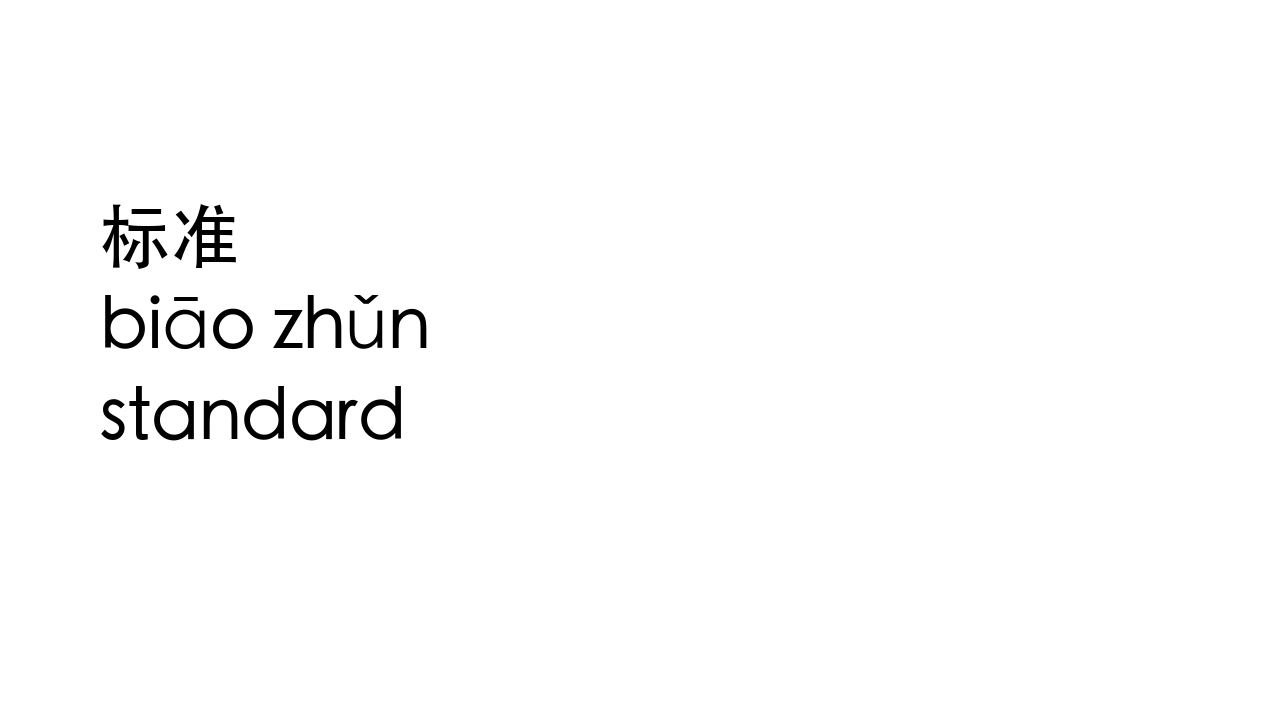

In [35]:
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, CompositeVideoClip, AudioFileClip
hanzi_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # Example font path

# Function to create text clips for a single vocabulary word
def create_text_clip_old(chinese, pinyin, english, duration_text_c, duration_text_e, timestamp_c, timestamp_e, size=(1280, 720), bg_color='white', text_color='black', font=hanzi_font_path):
    # # Chinese + Pinyin appear first
    # text_c = f"{chinese}\n{pinyin}"
    # clip_c = TextClip(text=text_c, font='Marker Felt', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_c)
    
    # # Chinese + English
    # text_e = f"{chinese}\n{pinyin}\n{english}"
    # clip_e = TextClip(text=text_e, font='Arial', font_size=70, color=text_color, bg_color=bg_color, size=size, method='label', duration=duration_text_e)
    # return [clip_c, clip_e]

    # Create an image with Chinese text
    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(hanzi_font_path, 70)
    text = f"{chinese}\n{pinyin}"
    draw.multiline_text((100, 200), text, font=font, fill=text_color, spacing=30)
    img.save(f"audio_files/img_for_video/{chinese}_chinese.png")
    clip_chinese = ImageClip(f"audio_files/img_for_video/{chinese}_chinese.png", duration=duration_text_c)
    clip_chinese = clip_chinese.with_start(timestamp_c)

    # Create an image with English text
    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(hanzi_font_path, 70)
    text = f"{chinese}\n{pinyin}\n{english}"
    draw.multiline_text((100, 200), text, font=font, fill=text_color, spacing=30)
    img.save(f"audio_files/img_for_video/{chinese}_english.png")
    clip_english = ImageClip(f"audio_files/img_for_video/{chinese}_english.png", duration=duration_text_e)
    clip_english = clip_english.with_start(timestamp_e)
    return [clip_chinese, clip_english]


def create_text_clip(text, duration, timestamp_start, image_file_name, size=(1280, 720), bg_color='white', text_color='black', font_path=hanzi_font_path):
    img = Image.new("RGB", size, color=bg_color)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, 70)
    draw.multiline_text((100, 200), text, font=font, fill=text_color, spacing=30)
    img.save(f"audio_files/img_for_video/{image_file_name}.png")
    clip = ImageClip(f"audio_files/img_for_video/{image_file_name}.png", duration=duration).with_start(timestamp_start)
    return clip
    
# Create all clips
clips = []
for idx, row in df_video.iterrows():
    clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['duration_text_c'], row['timestamp_c'], f"{row['chinese']}_chinese"))
    clips.append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{row['english']}", row['duration_text_e'], row['timestamp_e'], f"{row['chinese']}_english"))
    clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['duration_sent_c'], row['timestamp_sent_c'], f"{row['chinese']}_sentence"))
    clips.append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['duration_sent_e'], row['timestamp_sent_e'], f"{row['chinese']}_sentence_e"))

clips[1].display_in_notebook() 

In [23]:
dir(clips[0])

['_TEMP_FILES_PREFIX',
 '__add__',
 '__and__',
 '__class__',
 '__copy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 'aspect_ratio',
 'audio',
 'close',
 'compose_mask',
 'compose_on',
 'copy',
 'cropped',
 'display_in_notebook',
 'duration',
 'end',
 'fill_array',
 'frame_function',
 'get_frame',
 'h',
 'has_constant_size',
 'image_transform',
 'img',
 'is_mask',
 'is_playing',
 'iter_frames',
 'layer_index',
 'mask',
 'memoize',
 'memoized_frame',
 'memoized_t',
 'n_frames',
 'pos',
 'preview',
 'relative_p

In [36]:
# Load audio
audio = AudioFileClip(f"audio_files/products/001_0813_word_p1_k3_sent.mp3")
audio.duration

# Compare durations of audio and video
all_clips_duration = sum(clip.duration for clip in clips)
print(f"Audio: {audio.duration:.3f} seconds")
print(f"Video: {all_clips_duration:.3f} seconds")

Audio: 75.720 seconds
Video: 75.648 seconds


In [37]:
# Combine clips
video = CompositeVideoClip(clips, size=(1280,720))
video.audio = audio
video.duration = audio.duration

# Export video
video.write_videofile("audio_files/products/001_0813_word_p1_k3_sent.mp4", fps=24)

MoviePy - Building video audio_files/products/001_0813_word_p1_k3_sent.mp4.
MoviePy - Writing audio in 001_0813_word_p1_k3_sentTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/001_0813_word_p1_k3_sent.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/001_0813_word_p1_k3_sent.mp4


In [149]:
video?

Type:        CompositeVideoClip
String form: <moviepy.video.compositing.CompositeVideoClip.CompositeVideoClip object at 0x10d0f3770>
File:        ~/Library/Caches/pypoetry/virtualenvs/mandarin-data-nE21Vypf-py3.13/lib/python3.13/site-packages/moviepy/video/compositing/CompositeVideoClip.py
Docstring:  
A VideoClip made of other videoclips displayed together. This is the
base class for most compositions.

Parameters
----------

size
  The size (width, height) of the final clip.

clips
  A list of videoclips.

  Clips with a higher ``layer`` attribute will be displayed
  on top of other clips in a lower layer.
  If two or more clips share the same ``layer``,
  then the one appearing latest in ``clips`` will be displayed
  on top (i.e. it has the higher layer).

  For each clip:

  - The attribute ``pos`` determines where the clip is placed.
      See ``VideoClip.set_pos``
  - The mask of the clip determines which parts are visible.

  Finally, if all the clips in the list have their ``du

In [170]:
ImageClip?

Init signature:
ImageClip(
    img,
    is_mask=False,
    transparent=True,
    fromalpha=False,
    duration=None,
)
Docstring:     
Class for non-moving VideoClips.

A video clip originating from a picture. This clip will simply
display the given picture at all times.

Examples
--------

>>> clip = ImageClip("myHouse.jpeg")
>>> clip = ImageClip( someArray ) # a Numpy array represent

Parameters
----------

img
  Any picture file (png, tiff, jpeg, etc.) as a string or a path-like object,
  or any array representing an RGB image (for instance a frame from a VideoClip).

is_mask
  Set this parameter to `True` if the clip is a mask.

transparent
  Set this parameter to `True` (default) if you want the alpha layer
  of the picture (if it exists) to be used as a mask.

Attributes
----------

img
  Array representing the image of the clip.
File:           ~/Library/Caches/pypoetry/virtualenvs/mandarin-data-nE21Vypf-py3.13/lib/python3.13/site-packages/moviepy/video/VideoClip.py
Type:       